In [1]:
# import things
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify


c:\Users\Asusu\anaconda3\envs\y2_block_b\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Asusu\anaconda3\envs\y2_block_b\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Asusu\anaconda3\envs\y2_block_b\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Load the model trained
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'rafal_234778_unet_model_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [ ]:
# Define post-processing function
def post_process(predicted_mask, threshold=0.5):
    return (predicted_mask > threshold).astype(np.uint8)


In [5]:
def crop_and_preprocess_image(image_path, crop_margin=100, threshold=30):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    
    height, width, _ = image.shape
    cropped_image = image[:, crop_margin:width - crop_margin]  # Horizontal cropping
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours found in the image.")
    
    # Get the largest contour and its bounding box
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the region of interest
    final_image = cropped_image[y:y+h, x:x+w]
    final_image_gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
    normalized_image = final_image_gray.astype('float32') / 255.0
    
    # Return cropped image and coordinates
    return normalized_image, crop_margin, x, y, w, h



In [6]:
def display_cropped_and_mask(image_path, model, patch_size=(256, 256), threshold=0.5):
    try:
        # Step 1: Load the original image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")
        print("Original image shape:", image.shape)

        # Step 2: Preprocess and crop the image, and get cropping coordinates
        petri_dish, crop_margin, x_offset, y_offset, crop_width, crop_height = crop_and_preprocess_image(image_path)
        print("Petri dish (cropped image) shape:", petri_dish.shape)

        # Step 3: Pad the petri dish to ensure it is divisible by the patch size
        target_height = (petri_dish.shape[0] // patch_size[0] + 1) * patch_size[0]
        target_width = (petri_dish.shape[1] // patch_size[1] + 1) * patch_size[1]
        petri_dish_padded = cv2.copyMakeBorder(petri_dish, 0, target_height - petri_dish.shape[0], 
                                               0, target_width - petri_dish.shape[1], 
                                               cv2.BORDER_CONSTANT, value=0)
        print("Petri dish (padded) shape:", petri_dish_padded.shape)

        # Step 4: Patchify the padded image
        patches = patchify(petri_dish_padded, patch_size, step=patch_size[0])
        patches_shape = patches.shape
        patches = patches.reshape(-1, *patch_size)
        patches = patches[..., np.newaxis]

        # Step 5: Predict for each patch
        predicted_patches = [model.predict(np.expand_dims(p, axis=0))[0, :, :, 0] for p in patches]
        predicted_patches = np.array(predicted_patches)

        # Step 6: Unpatchify to reconstruct the predicted mask
        predicted_patches = predicted_patches.reshape(patches_shape[:-2] + patch_size)
        predicted_mask = unpatchify(predicted_patches, petri_dish_padded.shape)
        refined_mask = post_process(predicted_mask, threshold=threshold)
        print("Predicted mask shape (padded):", refined_mask.shape)

        # Step 7: Reverse padding to match the cropped petri dish size
        corrected_mask = refined_mask[:petri_dish.shape[0], :petri_dish.shape[1]]
        print("Corrected mask shape (cropped):", corrected_mask.shape)

        # Step 8: Place the mask back onto the original image
        final_mask = np.zeros(image.shape, dtype=np.uint8)
        final_mask[y_offset:y_offset + crop_height, 
                   crop_margin + x_offset:crop_margin + x_offset + crop_width] = corrected_mask
        print("Final mask shape (original image size):", final_mask.shape)

        # Display the cropped petri dish and the mask side by side
        f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
        ax[0].imshow(petri_dish, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Cropped Petri Dish')

        ax[1].imshow(final_mask, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('Predicted Mask')

        plt.tight_layout()
        plt.show()

        return final_mask

    except Exception as e:
        print(f"Error: {e}")
        return None




In [7]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


Original image shape: (3006, 4112)
Petri dish (cropped image) shape: (2803, 2806)
Petri dish (padded) shape: (2816, 2816)
1/1 [==============================] - 0s 73ms/step
Predicted mask shape (padded): (2816, 2816)
Corrected mask shape (cropped): (2803, 2806)
Final mask shape (original image size): (3006, 4112)


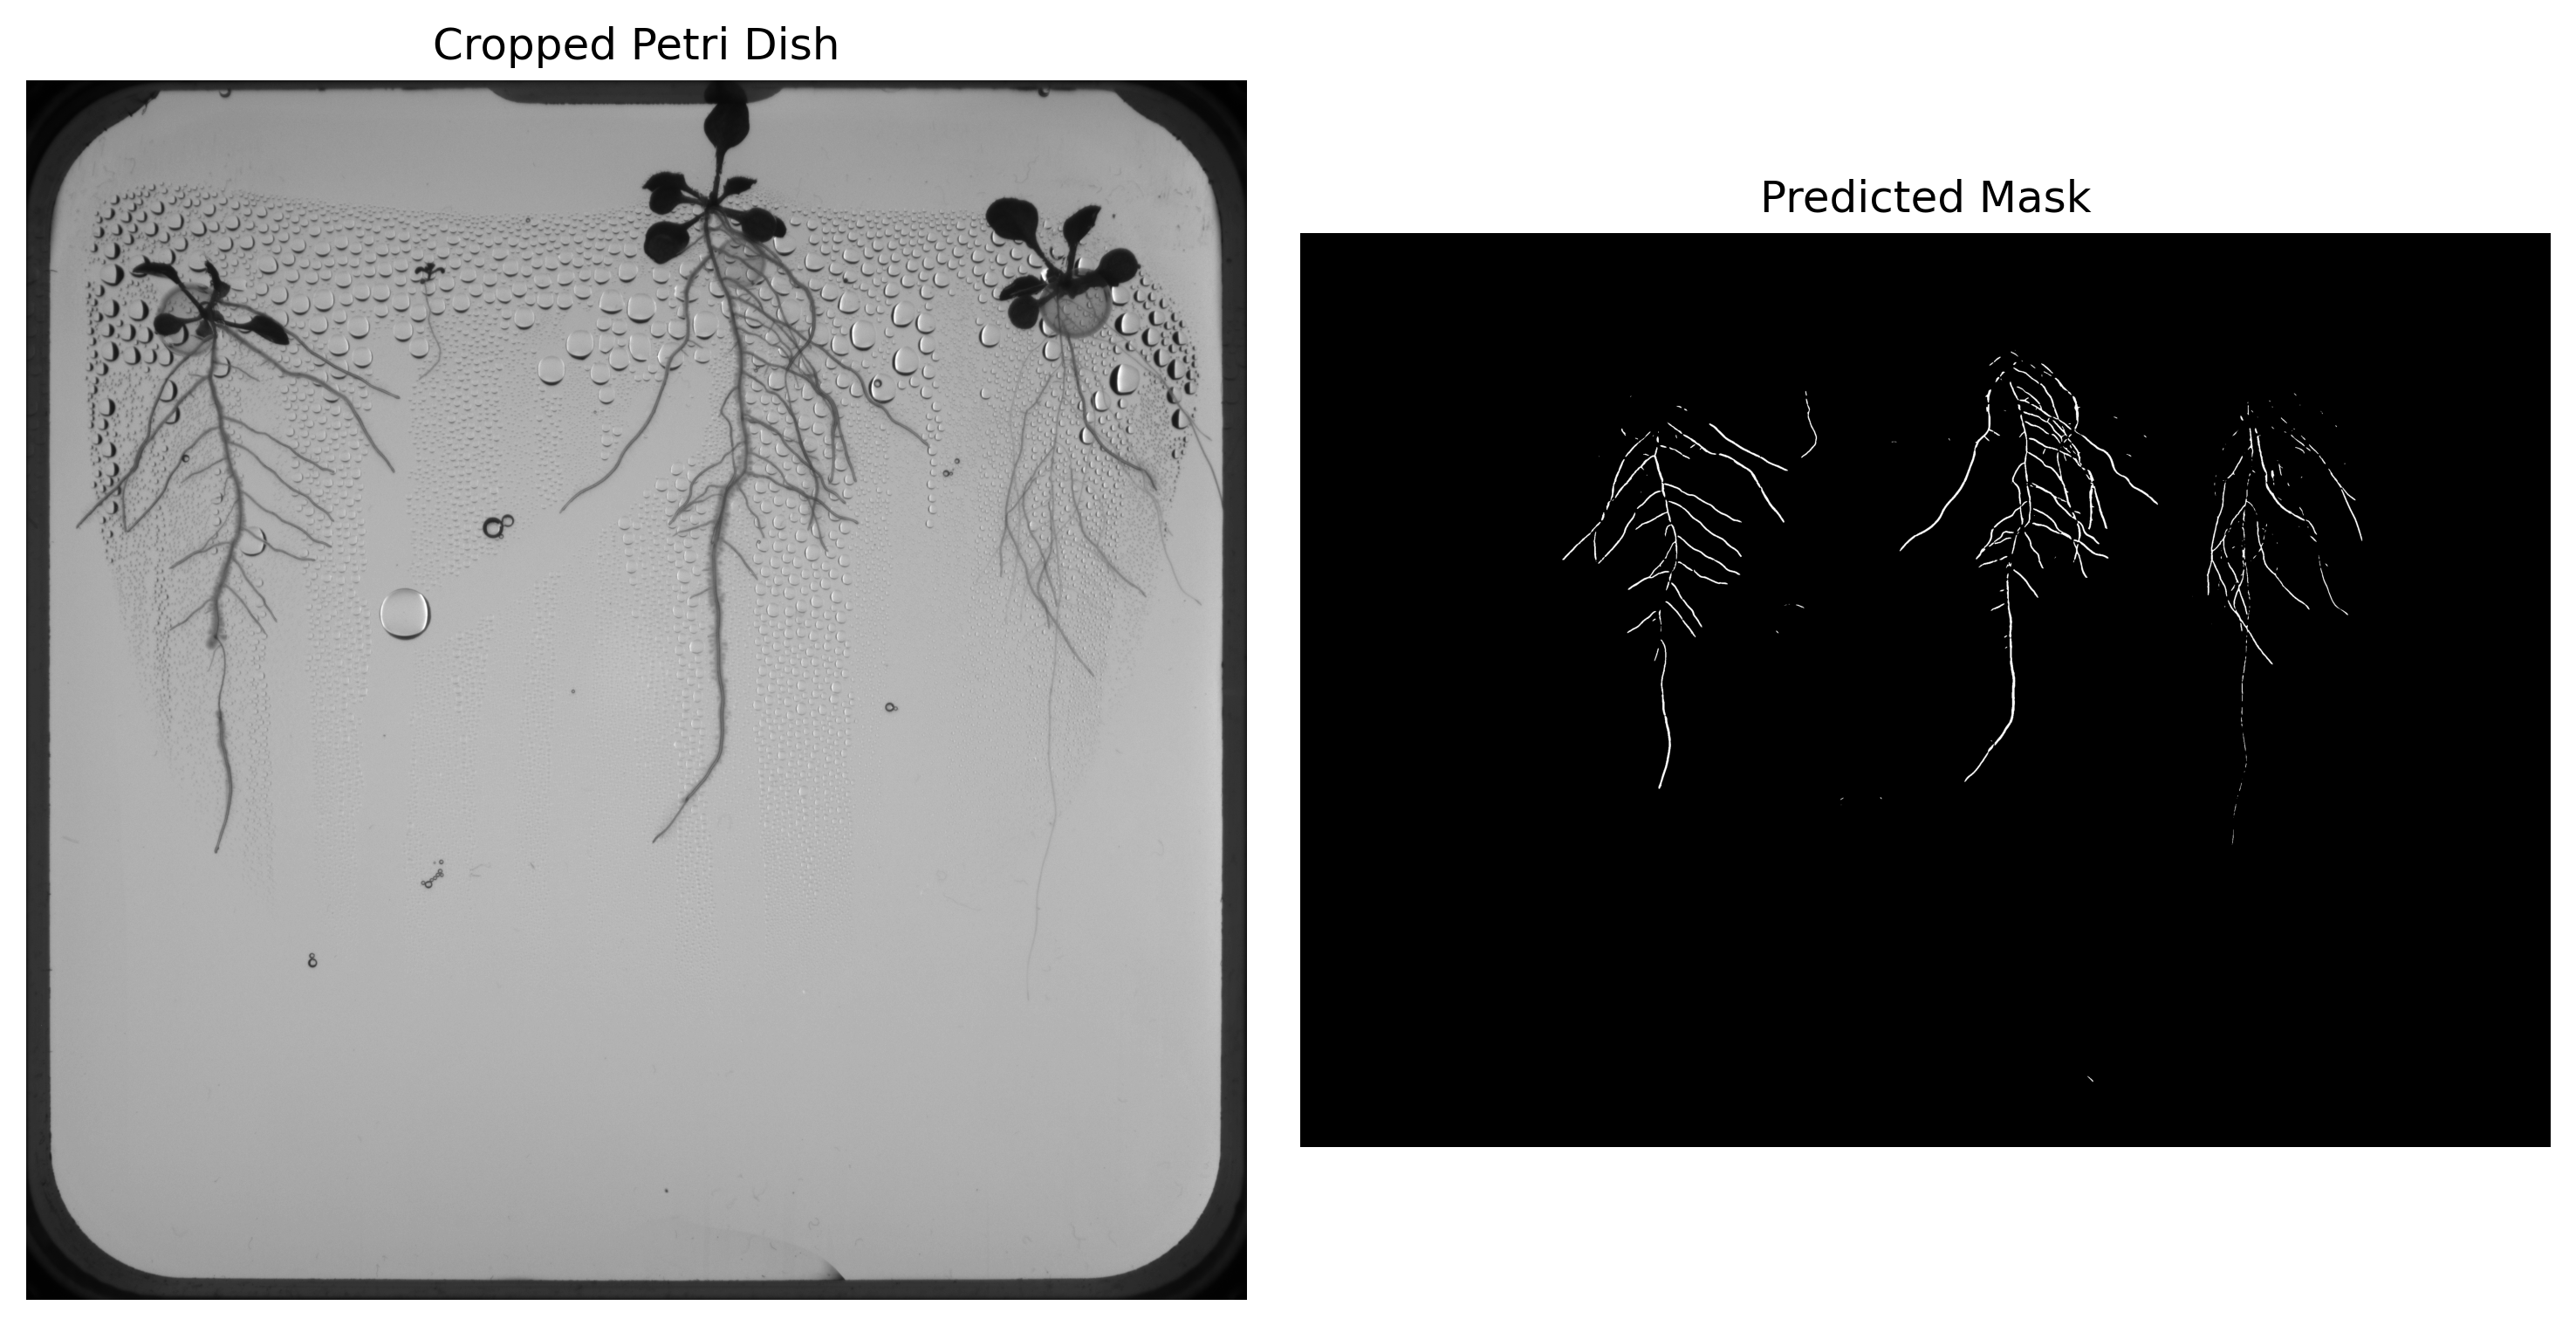

In [8]:
final_mask = display_cropped_and_mask(task5_test_image_path, model, patch_size=(256, 256), threshold=0.5)



In [ ]:
# plt.figure(dpi=300)
# plt.imshow(overlay_image)

Original image shape: (3006, 4112, 3)


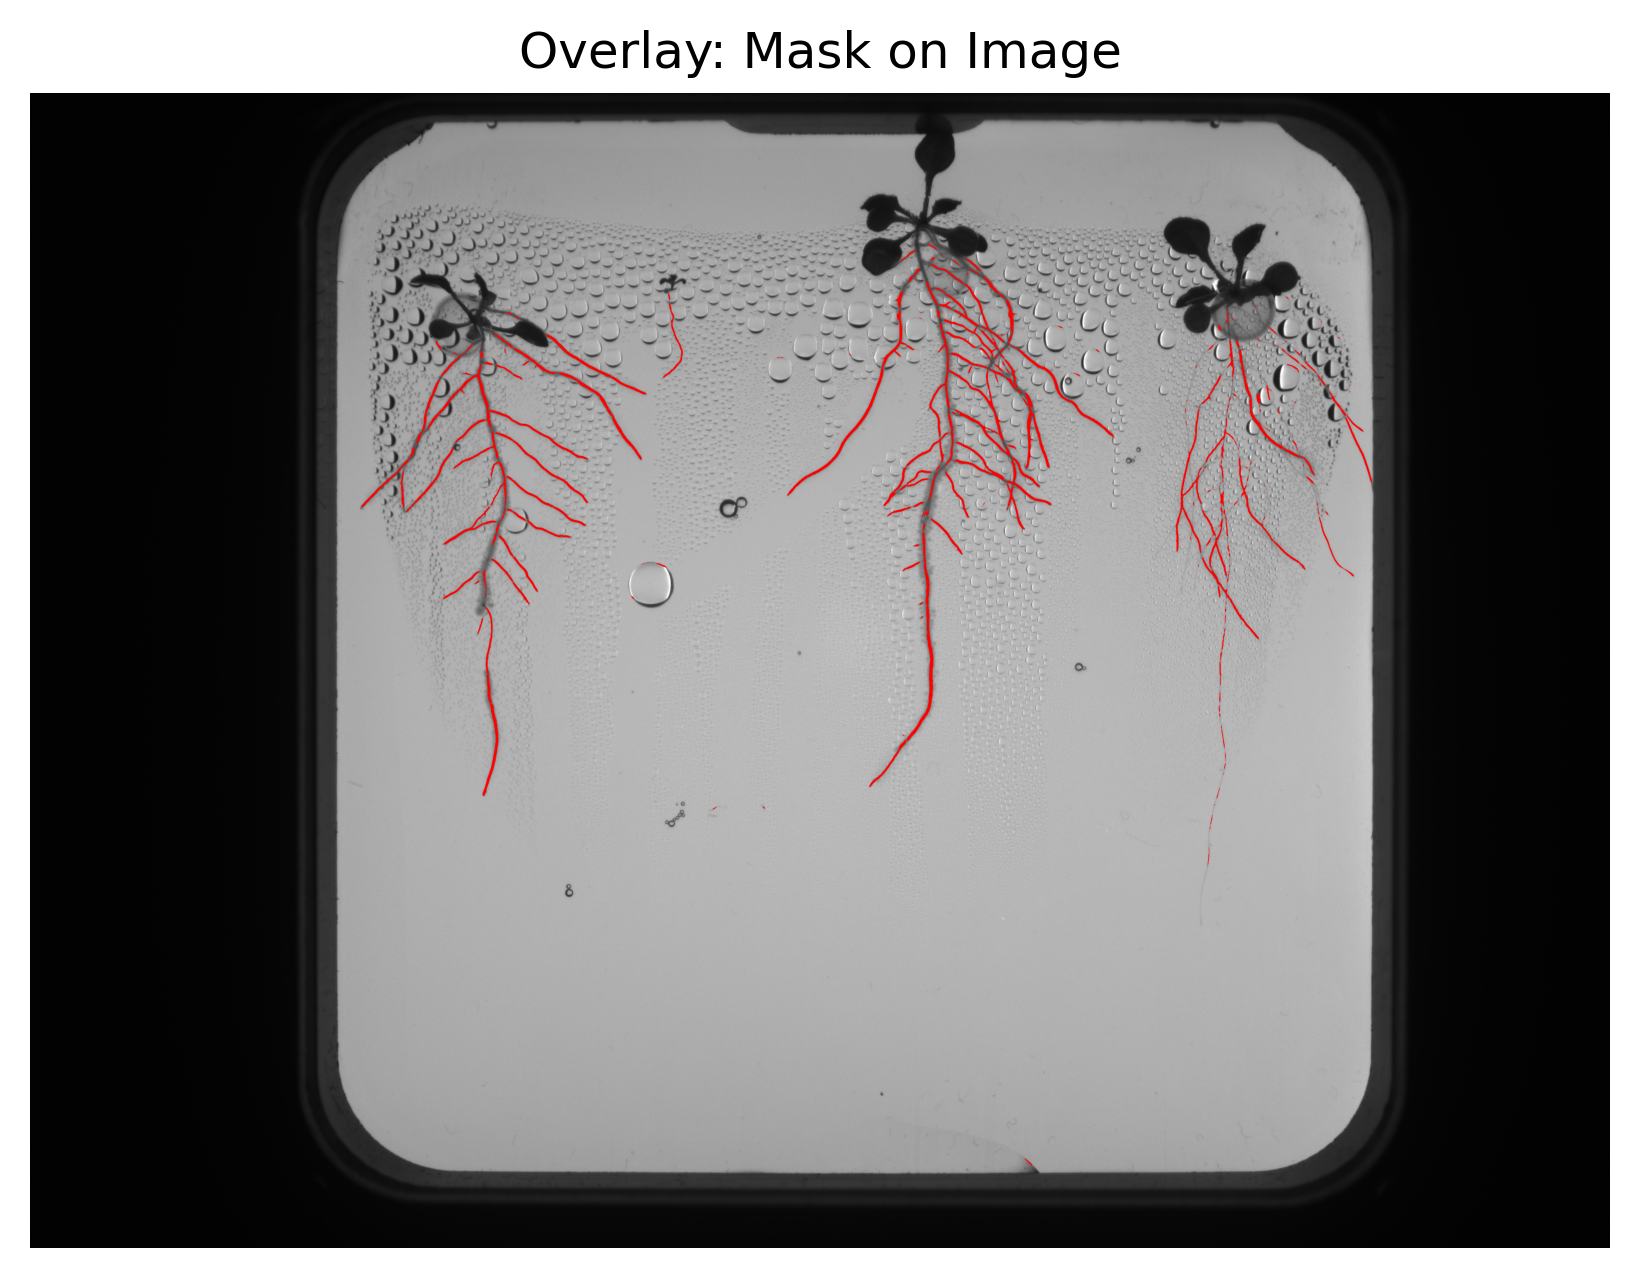

In [10]:
def display_overlay(image_path, final_mask):
    try:
        # Step 1: Load the original image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
        print("Original image shape:", image.shape)

        # Step 2: Create an overlay by coloring the mask
        overlay = image.copy()
        overlay[final_mask > 0] = [255, 0, 0] 

        # Display the overlay
        plt.figure(dpi=300, figsize=(10, 5))
        plt.imshow(overlay)
        plt.axis('off')
        plt.title('Overlay: Mask on Image')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

display_overlay('task5_test_image.png', final_mask)




In [11]:
def save_predicted_mask(image_path, model, student_name, student_number, patch_size=(256, 256), threshold=0.5):
    try:
        # Step 1: Load the original image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")
        print("Original image shape:", image.shape)

        # Step 2: Preprocess and crop the image, and get cropping coordinates
        petri_dish, crop_margin, x_offset, y_offset, crop_width, crop_height = crop_and_preprocess_image(image_path)
        print("Petri dish (cropped image) shape:", petri_dish.shape)

        # Step 3: Pad the petri dish to ensure it is divisible by the patch size
        target_height = (petri_dish.shape[0] // patch_size[0] + 1) * patch_size[0]
        target_width = (petri_dish.shape[1] // patch_size[1] + 1) * patch_size[1]
        petri_dish_padded = cv2.copyMakeBorder(petri_dish, 0, target_height - petri_dish.shape[0], 
                                               0, target_width - petri_dish.shape[1], 
                                               cv2.BORDER_CONSTANT, value=0)
        print("Petri dish (padded) shape:", petri_dish_padded.shape)

        # Step 4: Patchify the padded image
        patches = patchify(petri_dish_padded, patch_size, step=patch_size[0])
        patches_shape = patches.shape
        patches = patches.reshape(-1, *patch_size)
        patches = patches[..., np.newaxis]

        # Step 5: Predict for each patch
        predicted_patches = [model.predict(np.expand_dims(p, axis=0))[0, :, :, 0] for p in patches]
        predicted_patches = np.array(predicted_patches)

        # Step 6: Unpatchify to reconstruct the predicted mask
        predicted_patches = predicted_patches.reshape(patches_shape[:-2] + patch_size)
        predicted_mask = unpatchify(predicted_patches, petri_dish_padded.shape)
        refined_mask = post_process(predicted_mask, threshold=threshold)
        print("Predicted mask shape (padded):", refined_mask.shape)

        # Step 7: Reverse padding to match the cropped petri dish size
        corrected_mask = refined_mask[:petri_dish.shape[0], :petri_dish.shape[1]]
        print("Corrected mask shape (cropped):", corrected_mask.shape)

        # Step 8: Place the mask back onto the original image
        final_mask = np.zeros(image.shape, dtype=np.uint8)
        final_mask[y_offset:y_offset + crop_height, 
                   crop_margin + x_offset:crop_margin + x_offset + crop_width] = corrected_mask
        print("Final mask shape (original image size):", final_mask.shape)

        # Step 9: Convert the mask to binary with roots (255) and non-roots (0)
        mask_image = (final_mask * 255).astype(np.uint8)

        # Step 10: Save the mask with the required naming convention
        output_filename = f"{image_path.split('/')[-1].split('.')[0]}_prediction_{student_name}_{student_number}.png"
        cv2.imwrite(output_filename, mask_image)
        print(f"Predicted mask saved as {output_filename}")

        return mask_image

    except Exception as e:
        print(f"Error: {e}")
        return None

# Save the predicted mask using the required naming convention
saved_mask = save_predicted_mask('task5_test_image.png', model, 'rafal', '234778', patch_size=(256, 256), threshold=0.5)


Original image shape: (3006, 4112)
Petri dish (cropped image) shape: (2803, 2806)
Petri dish (padded) shape: (2816, 2816)
1/1 [==============================] - 0s 64ms/step
Predicted mask shape (padded): (2816, 2816)
Corrected mask shape (cropped): (2803, 2806)
Final mask shape (original image size): (3006, 4112)
Predicted mask saved as task5_test_image_prediction_rafal_234778.png
